# Lorenz Curves and Gini Coefficients

-----

#### John Stachurski

#### Prepared for the CBC Computational Workshop (May 2024)

-----

This notebook contains some exercises related to the Lorenz curve and the Gini
coefficient, which are often used to study inequality.

Our task will be to compute and examine these curves and values.

Uncomment the following if necessary

In [1]:
#!pip install quantecon 

We use the following imports.

In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

## The Lorenz curve 

Let's start by examining the Lorenz curve.

### Definition

Let $w_1, \ldots, w_n$ be a sample of observations of wealth (or income, or consumption, or firm sizes, etc.) in a population.

Suppose the sample has been sorted from smallest to largest.

The Lorenz curve takes this sample and produces a curve $L$.

To create it we first generate data points $(x_i, y_i)_{i=0}^n$  according to

\begin{equation*}
    x_0 = y_0 = 0
    \qquad \text{and, for $i \geq 1$,} \quad
    x_i = \frac{i}{n},
    \qquad
    y_i =
       \frac{\sum_{j \leq i} w_j}{\sum_{j \leq n} w_j}  
\end{equation*}

Now the Lorenz curve $L$ is formed from these data points using interpolation.

The meaning of the statement $y = L(x)$ is that the lowest $(100 \times x)$\% of
people have $(100 \times y)$\% of all wealth.

* if $x=0.5$ and $y=0.1$, then the bottom 50% of the population
  owns 10% of the wealth.

### Using QuantEcon's routine

Let's look at an example.

First we generate $n=2000$ draws from a lognormal distribution and treat these draws as our population.

In [3]:
n = 2000
sample = np.exp(np.random.randn(n))       # Lognormal sample

We then generate the Lorenz curve using a routine from `quantecon`.

In [4]:
x, y = qe.lorenz_curve(sample)            # QuantEcon routine (no need to sort)

Now let's plot.

The straight line ($x=L(x)$ for all $x$) corresponds to perfect equality.  

The lognormal draws produce a less equal distribution.

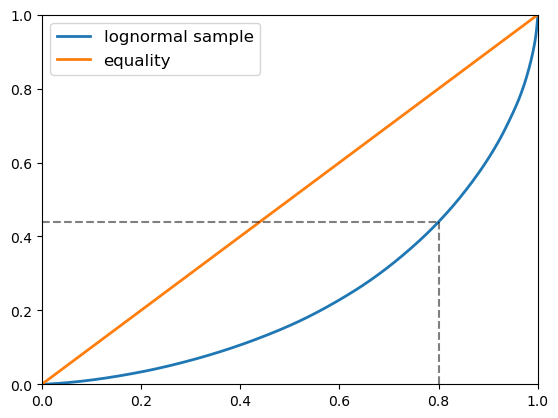

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

For example, if we imagine these draws as being observations of wealth across a
sample of households, then the dashed lines show that the bottom 80\% of
households own just over 40\% of total wealth.

### Exercise: write a NumPy version

Using the definition of the Lorenz curve given above and NumPy, try to write
your own version of `qe.lorenz_curve`.  

See if you can write a version without any explicity loops.

Try to replicate the figure above, using the same lognormal data set.

In [6]:
# Put your code here

In [7]:
for i in range(16):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


Here's one solution:

In [8]:
def lorenz_curve(w):
    n = len(w)
    w = np.sort(w)
    x = np.arange(n + 1) / n
    s = np.concatenate((np.zeros(1), np.cumsum(w)))
    y = s / s[n]
    return x, y

Let's test it:

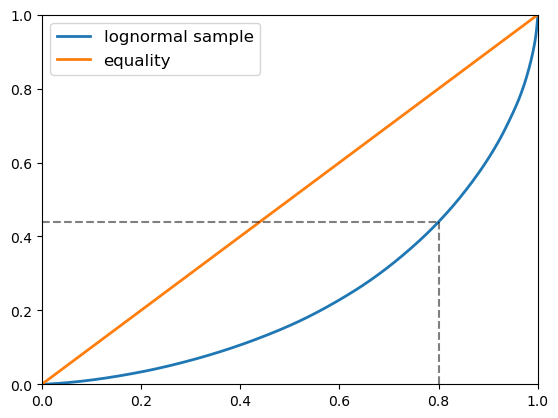

In [9]:
x, y = lorenz_curve(sample)    # Our routine

fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

### A Numba version

If you prefer, you can use a for loop accelerated by Numba to compute the
Lorenz curve:

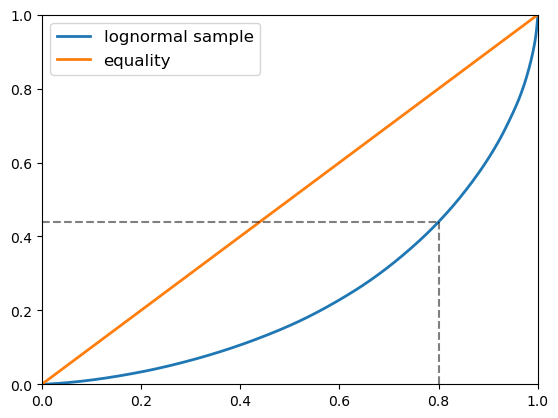

In [10]:
@numba.jit
def lorenz_curve(w):
    n = len(w)
    w = np.sort(w)
    s = np.zeros(n + 1)
    s[1:] = np.cumsum(w)  # s[i] = sum_{j <= i} w_j
    x = np.zeros(n + 1)
    y = np.zeros(n + 1)
    for i in range(1, n + 1):
        x[i] = i / n
        y[i] = s[i] / s[n]
    return x, y


x, y = lorenz_curve(sample)    # Our routine

fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

## The Gini coefficient

Now let's examine the Gini coefficient.


### Definition


Continuing to assume that $w_1, \ldots, w_n$ has been sorted from smallest to largest,
the Gini coefficient of the sample is defined by

\begin{equation}
    \label{eq:gini}
    G :=
    \frac
        {\sum_{i=1}^n \sum_{j = 1}^n |w_j - w_i|}
        {2n\sum_{i=1}^n w_i}.
\end{equation}



### Using QuantEcon's routine

Let's study the Gini coefficient in some simulations using `gini_coefficient`
from `quantecon`.

The following code computes the Gini coefficients for five different populations.

Each of these populations is generated by drawing from a lognormal distribution with parameters $\mu$ (mean) and $\sigma$ (standard deviation).

To create the five populations, we vary $\sigma$ over a grid of length $5$
between $0.2$ and $4$.

In each case we set $\mu = - \sigma^2 / 2$, so that the mean of the distribution does not change with $\sigma$.

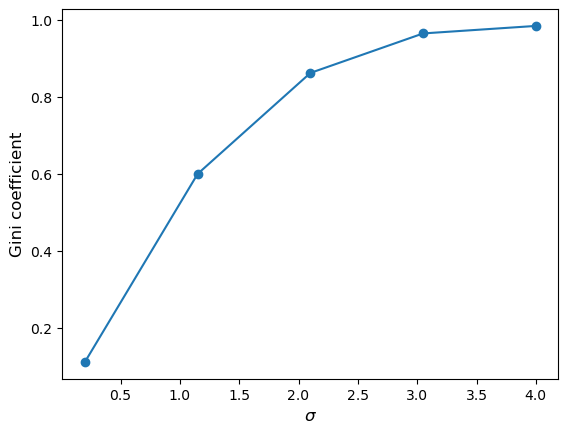

In [11]:
k = 5
σ_vals = np.linspace(0.2, 4, k)
n = 2_000
ginis = []
for σ in σ_vals:
    # Generate the data
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    ginis.append(qe.gini_coefficient(y))  # Uses quantecon routine

fig, ax = plt.subplots()
ax.plot(σ_vals, ginis, marker='o')
ax.set_xlabel('$\sigma$', fontsize=12)
ax.set_ylabel('Gini coefficient', fontsize=12)
plt.show()

The plots show that inequality rises with $\sigma$ (as measured by the Gini coefficient).

### A NumPy version

Let's write our own function to compute the Gini coefficient.

We'll start with a NumPy version that uses vectorized code to avoid loops.

In [12]:
def gini(w):
    w_size = len(w)
    w_1 = np.reshape(w, (w_size, 1))
    w_2 = np.reshape(w, (1, w_size))
    g_sum = np.sum(np.abs(w_1 - w_2))
    return g_sum / (2 * w_size * np.sum(w))

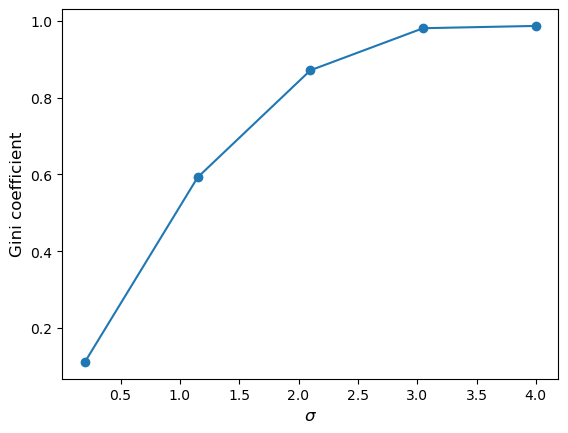

In [13]:
ginis = []
for σ in σ_vals:
    # Generate the data
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    ginis.append(gini(y))  # Use our NumPy version

fig, ax = plt.subplots()
ax.plot(σ_vals, ginis, marker='o')
ax.set_xlabel('$\sigma$', fontsize=12)
ax.set_ylabel('Gini coefficient', fontsize=12)
plt.show()

Notice, however, that the NumPy version of the Gini function is very memory intensive, since we create large intermediate arrays.

For example, consider the following

In [14]:
w = np.exp(np.random.randn(1_000_000))
w.sort()

In [15]:
gini(w)

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

Unless you have massive memory, the code above gives an out-of-memory error.

The next exercise asks you to write a more memory efficient version.

### Exercise: A Numba version

Try to write your own function that computes the Gini coefficient, this time
using Numba and loops to produce effient code

* Try to replicate the Gini figure above.
* If possible, parallelize one of the loops
* See if your code runs on `w = np.exp(np.random.randn(1_000_000))`

In [16]:
# Put your code here

In [17]:
for i in range(18):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


Here's one solution.

Notice how easy it is to parallelize the loop --- even though `s` is common across the outer loops, which violates independence, this loop is still efficiently parallelized.

In [18]:
@numba.jit(parallel=True)
def gini_numba(w):
    n = len(w)
    s = 0.0
    for i in numba.prange(n):
        for j in range(n):
            s += abs(w[i] - w[j])
    return s / (2 * n * np.sum(w))

Let's recreate the figure.

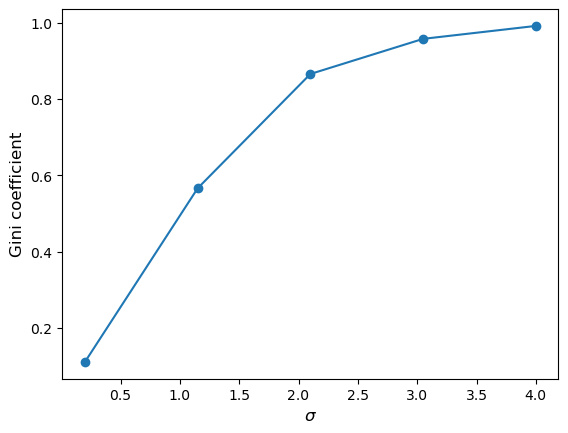

In [19]:
ginis = []

for σ in σ_vals:
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    ginis.append(gini_numba(y))  # Use Numba version


fig, ax = plt.subplots()
ax.plot(σ_vals, ginis, marker='o')
ax.set_xlabel('$\sigma$', fontsize=12)
ax.set_ylabel('Gini coefficient', fontsize=12)
plt.show()

And let's see if it works on the large data set we considered above.

(Note that it will take a couple of minutes to run!)

In [ ]:
w = np.exp(np.random.randn(1_000_000))
w.sort()
gini_numba(w)